In [1]:
%matplotlib inline

In [2]:
import os, sys
import glob
import re
import math
import time
import numpy as np
from uncertainties import unumpy as unp
import uncertainties.umath as umath
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat

In [3]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 1.5

In [4]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
# unit conversion
# 1 Ha = 4.3597482*e-18 J
# 1 angstrom = 1.0*10e-10 m
# 1 atomic unit = 1.66057*10e-27 kg
# 1 THz = 33.35641 cm-1
Ry_to_J = 2.17987 * 10**-18
Ha_to_J = Ry_to_J * 2.0
J_to_Ha = 1.0 / Ha_to_J
aumass_to_kg = 1.66054 * 10**-27
bohr_to_m = 5.29177210903 * 10**-11
bohr_to_ang = 0.529177210903
ang_to_bohr = 1.0 / bohr_to_ang
m_to_bohr = 1.0 / bohr_to_m
au_to_GPa = (4.359e-18) / (0.5291772e-10) ** 3 * (10**-9)
KBar_to_Ha_bohr = 10**8 * J_to_Ha / (m_to_bohr) ** 3
Ha_bohr_to_KBar = 1.0 / KBar_to_Ha_bohr
# au_to_GPa = 1 a.u. = 1 Hartree/(1 Bohr)^3 = (4.359e-18 J)/(0.5291772e-10 m)^3 * (10**-12)

In [6]:
try:
    import ipynb_path

    root_dir = os.path.dirname(ipynb_path.get())
except ModuleNotFoundError:
    root_dir = "/mnt/data/kosuke/45jQMC/XX"
os.chdir(root_dir)
root_dir

'/Users/kosuke/applications/jQMC/examples/example02'

In [7]:
# def read
def read_vmc_num_mcmc(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Total.*elapsed.*time.*for.*MCMC.*", line):
                num_gfmc_steps = float(line.split()[5])
                return num_gfmc_steps
        return np.nan

In [8]:
# def read
def read_lrdmc_num_branching(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Total.*GFMC.*time.*for.*", line):
                num_gfmc_steps = float(line.split()[4])
                return num_gfmc_steps
        return np.nan

In [9]:
# def read
def read_vmc_elapsed_time(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Net.*total.*time.*for.*MCMC.*", line):
                elapsed_time = float(line.split()[6])
                return elapsed_time
        return np.nan

In [10]:
# def read
def read_lrdmc_elapsed_time(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Net.*GFMC.*time.*without.*pre-compilations.*", line):
                elapsed_time = float(line.split()[6])
                return elapsed_time
        return np.nan

In [15]:
mol_list = ["01water_jqmc", "02water_dimer_jqmc", "03benzene_jqmc", "04benzene_dimer_jqmc"]
mol_label_list = [r"(a) Water", r"(b) Water dimer", r"(c) Benzene", r"(d) Benzene dimer"]
mol_label2_list = [r"Water", r"Water dimer", r"Benzene", r"Benzene dimer"]
'''
mol_list = ["01water_jqmc", "02water_dimer_jqmc", "03benzene_jqmc"]
mol_label_list = [r"Water ($N_e = 8$)", r"Water dimer ($N_e = 16$)", r"Benzene ($N_e = 30$)"]
mol_label2_list = [r"Water", r"Water dimer", r"Benzene"]
'''

'\nmol_list = ["01water_jqmc", "02water_dimer_jqmc", "03benzene_jqmc"]\nmol_label_list = [r"Water ($N_e = 8$)", r"Water dimer ($N_e = 16$)", r"Benzene ($N_e = 30$)"]\nmol_label2_list = [r"Water", r"Water dimer", r"Benzene"]\n'

In [16]:
param_dict={
    "01water_jqmc":
        {
            "nw_list" : [1, 2, 4, 10, 20, 30, 60, 120, 160, 200, 300, 400, 600, 800, 1000, 1200, 1600],
            "vmc_num_mcmc" : 100,
            "lrdmc_num_gfmc" : 100,
            "trial_num": 1
        },
    "02water_dimer_jqmc":
        {
            "nw_list" : [1, 2, 4, 10, 20, 30, 60, 120, 160, 200, 300, 400],
            "vmc_num_mcmc" : 100,
            "lrdmc_num_gfmc" : 100,
            "trial_num": 1
        },
    "03benzene_jqmc":
        {
            "nw_list" : [1, 2, 4, 10, 20, 30, 60, 120, 160, 200, 240, 300, 400],
            "vmc_num_mcmc" : 100,
            "lrdmc_num_gfmc" : 100,
            "trial_num": 1
        },
    "04benzene_dimer_jqmc":
        {
            "nw_list" : [1, 2, 4, 10, 20, 30, 60, 120],
            "vmc_num_mcmc" : 100,
            "lrdmc_num_gfmc" : 100,
            "trial_num": 1
        }
}

In [17]:
summary_vmc = {}

# files
out_vmc_gpu = "out_vmc_on_gpu"


for mol in mol_list:

    nw_list = param_dict[mol]["nw_list"]
    vmc_num_mcmc = param_dict[mol]["vmc_num_mcmc"]
    vmc_trial_num = param_dict[mol]["trial_num"]

    vmc_num_mcmc_np = []
    vmc_num_nw_np = []
    vmc_elapsed_time_np = []
    vmc_num_mcmc_num_walkers_per_sec_np = []

    for nw in nw_list:

        gpu_dirs = [os.path.join(root_dir, mol, "miyabi", f"nw_{nw}_trial_{i_trial}") for i_trial in range(vmc_trial_num)]

        vmc_elapsed_time = np.array([read_vmc_elapsed_time(os.path.join(gpu_dir, out_vmc_gpu)) for gpu_dir in gpu_dirs])
        vmc_elapsed_time = ufloat(np.mean(vmc_elapsed_time), np.std(vmc_elapsed_time))
        vmc_num_mcmc_num_walkers_per_sec = nw * vmc_num_mcmc / vmc_elapsed_time

        vmc_num_mcmc_np.append(vmc_num_mcmc)
        vmc_num_nw_np.append(nw)
        vmc_elapsed_time_np.append(vmc_elapsed_time)
        vmc_num_mcmc_num_walkers_per_sec_np.append(vmc_num_mcmc_num_walkers_per_sec)

    vmc_num_mcmc_np = np.array(vmc_num_mcmc_np)
    vmc_num_nw_np = np.array(vmc_num_nw_np)
    vmc_elapsed_time_np = np.array(vmc_elapsed_time_np)
    vmc_num_mcmc_num_walkers_per_sec_np = np.array(vmc_num_mcmc_num_walkers_per_sec_np)
    
    summary_vmc[mol] = {
        "vmc_num_mcmc_np": vmc_num_mcmc_np,
        "vmc_num_nw_np": vmc_num_nw_np,
        "vmc_elapsed_time_np": vmc_elapsed_time_np,
        "vmc_num_mcmc_num_walkers_per_sec_np": vmc_num_mcmc_num_walkers_per_sec_np,
    }

In [18]:
summary_lrdmc = {}

# files
out_lrdmc_gpu = "out_lrdmc_on_gpu"

for mol in mol_list:

    nw_list = param_dict[mol]["nw_list"]
    lrdmc_num_gfmc = param_dict[mol]["lrdmc_num_gfmc"]
    lrdmc_trial_num = param_dict[mol]["trial_num"]

    lrdmc_num_gfmc_np = []
    lrdmc_num_nw_np = []
    lrdmc_elapsed_time_np = []
    lrdmc_num_gfmc_num_walkers_per_sec_np = []

    for nw in nw_list:

        gpu_dirs = [os.path.join(root_dir, mol, "miyabi", f"nw_{nw}_trial_{i_trial}") for i_trial in range(lrdmc_trial_num)]

        lrdmc_elapsed_time = np.array([read_lrdmc_elapsed_time(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs])
        lrdmc_elapsed_time = ufloat(np.mean(lrdmc_elapsed_time), np.std(lrdmc_elapsed_time))
        lrdmc_num_gfmc_num_walkers_per_sec = nw * lrdmc_num_gfmc / lrdmc_elapsed_time

        lrdmc_num_gfmc_np.append(lrdmc_num_gfmc)
        lrdmc_num_nw_np.append(nw)
        lrdmc_elapsed_time_np.append(lrdmc_elapsed_time)
        lrdmc_num_gfmc_num_walkers_per_sec_np.append(lrdmc_num_gfmc_num_walkers_per_sec)
    
    lrdmc_num_gfmc_np = np.array(lrdmc_num_gfmc_np)
    lrdmc_num_nw_np = np.array(lrdmc_num_nw_np)
    lrdmc_elapsed_time_np = np.array(lrdmc_elapsed_time_np)
    lrdmc_num_gfmc_num_walkers_per_sec_np = np.array(lrdmc_num_gfmc_num_walkers_per_sec_np)

    summary_lrdmc[mol] = {
        "lrdmc_num_gfmc_np": lrdmc_num_gfmc_np,
        "lrdmc_num_nw_np": lrdmc_num_nw_np,
        "lrdmc_elapsed_time_np": lrdmc_elapsed_time_np,
        "lrdmc_num_gfmc_num_walkers_per_sec_np": lrdmc_num_gfmc_num_walkers_per_sec_np,
    }

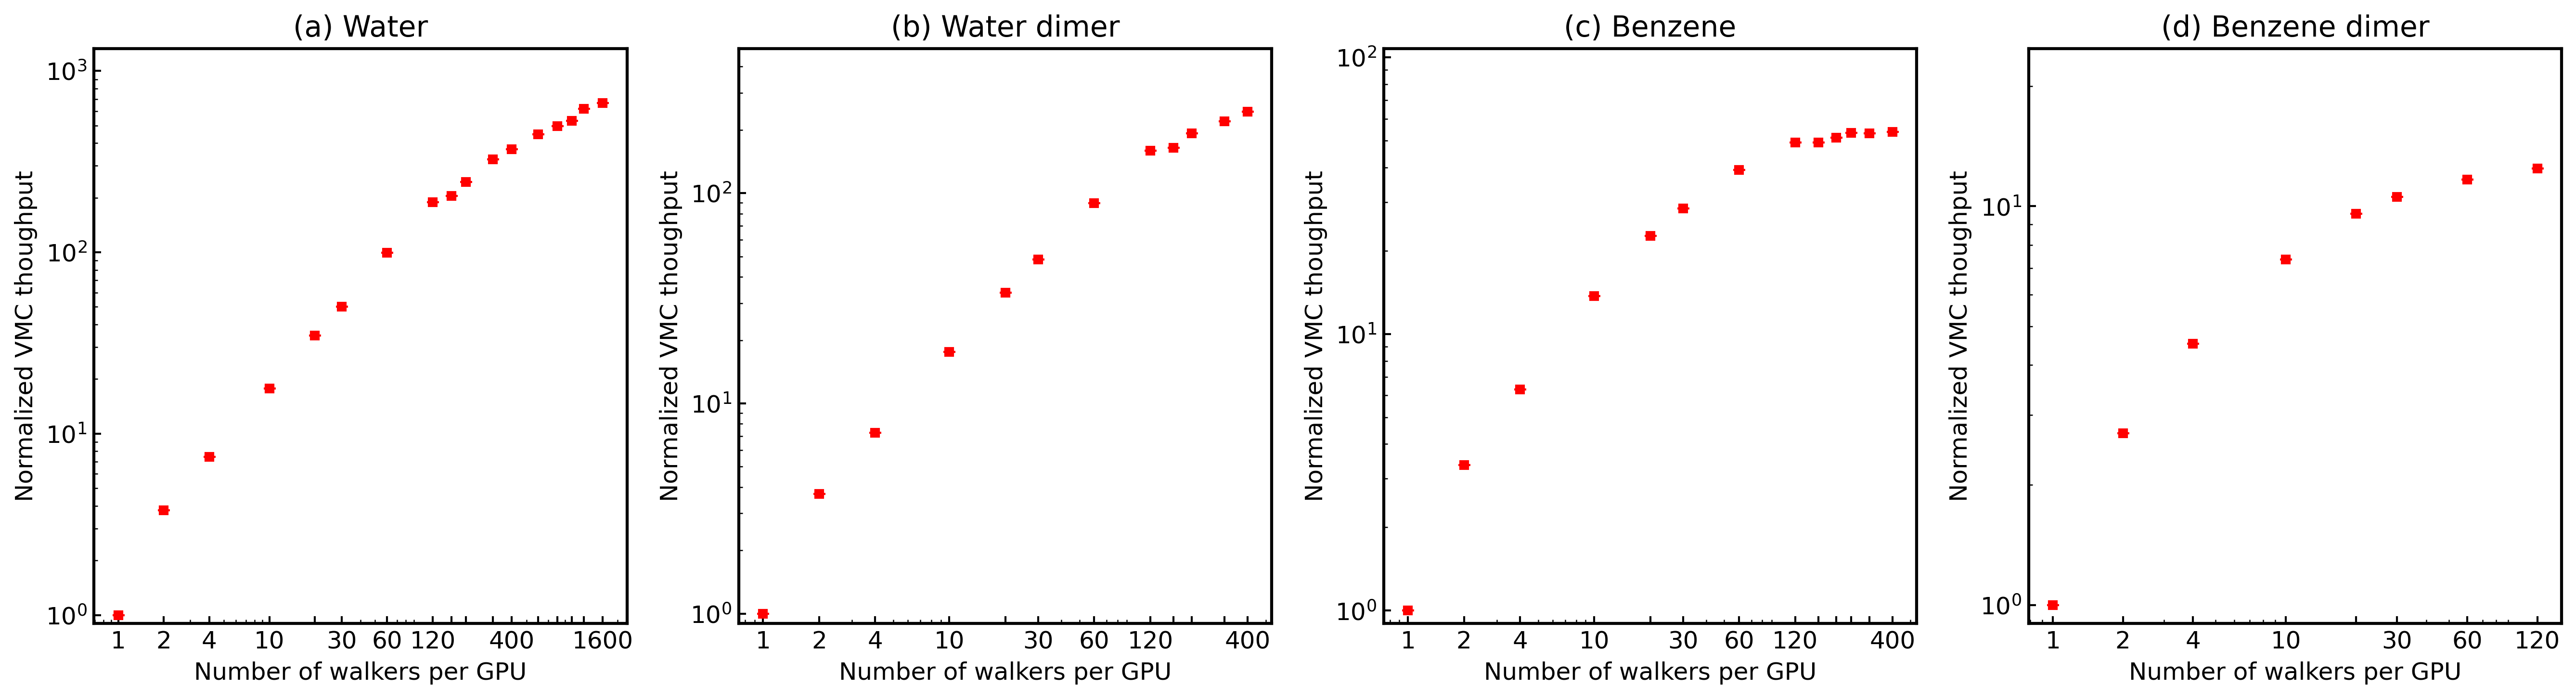

In [32]:
# plot Graph (VMC)
fig = plt.figure(figsize=(4.5 * len(mol_list), 5), facecolor="white", dpi=300, tight_layout=True)
plot_sigma=1
for i, mol in enumerate(mol_list):
    # plot Graph
    ax = fig.add_subplot(1, len(mol_list), i + 1)

    # labels
    ax.set_title(mol_label_list[i], wrap=True)
    ax.set_xlabel("Number of walkers per GPU")
    ax.set_ylabel(r"Normalized VMC thoughput")
    ax.set_xscale("log")
    ax.set_yscale("log")

    # GPU
    x = summary_vmc[mol]["vmc_num_nw_np"]
    y = summary_vmc[mol]["vmc_num_mcmc_num_walkers_per_sec_np"] / summary_vmc[mol]["vmc_num_mcmc_num_walkers_per_sec_np"][0]
    y_mean = np.array([v.n for v in y])
    y_std = np.array([v.s for v in y])
    ax.errorbar(x, y_mean, yerr=y_std*plot_sigma, color="r", marker="s", markersize=4, ls="", alpha=1.0, capsize=3)
    ax.set_xticks(summary_vmc[mol]["vmc_num_nw_np"])
    xticklabels = [str(t) for t in summary_vmc[mol]["vmc_num_nw_np"]]
    xticklabels = [
        "" if item in ["20", "160", "200", "240", "300", "360", "480", "600", "720", "800", "1000", "1200"] else item for item in xticklabels
    ]
    ax.set_xticklabels(xticklabels)
    ax.set_ylim([0.90, np.max(y_mean) * 2.0])

plt.savefig(f"jqmc_VMC_vectorization_benchmark.jpg")
plt.show()

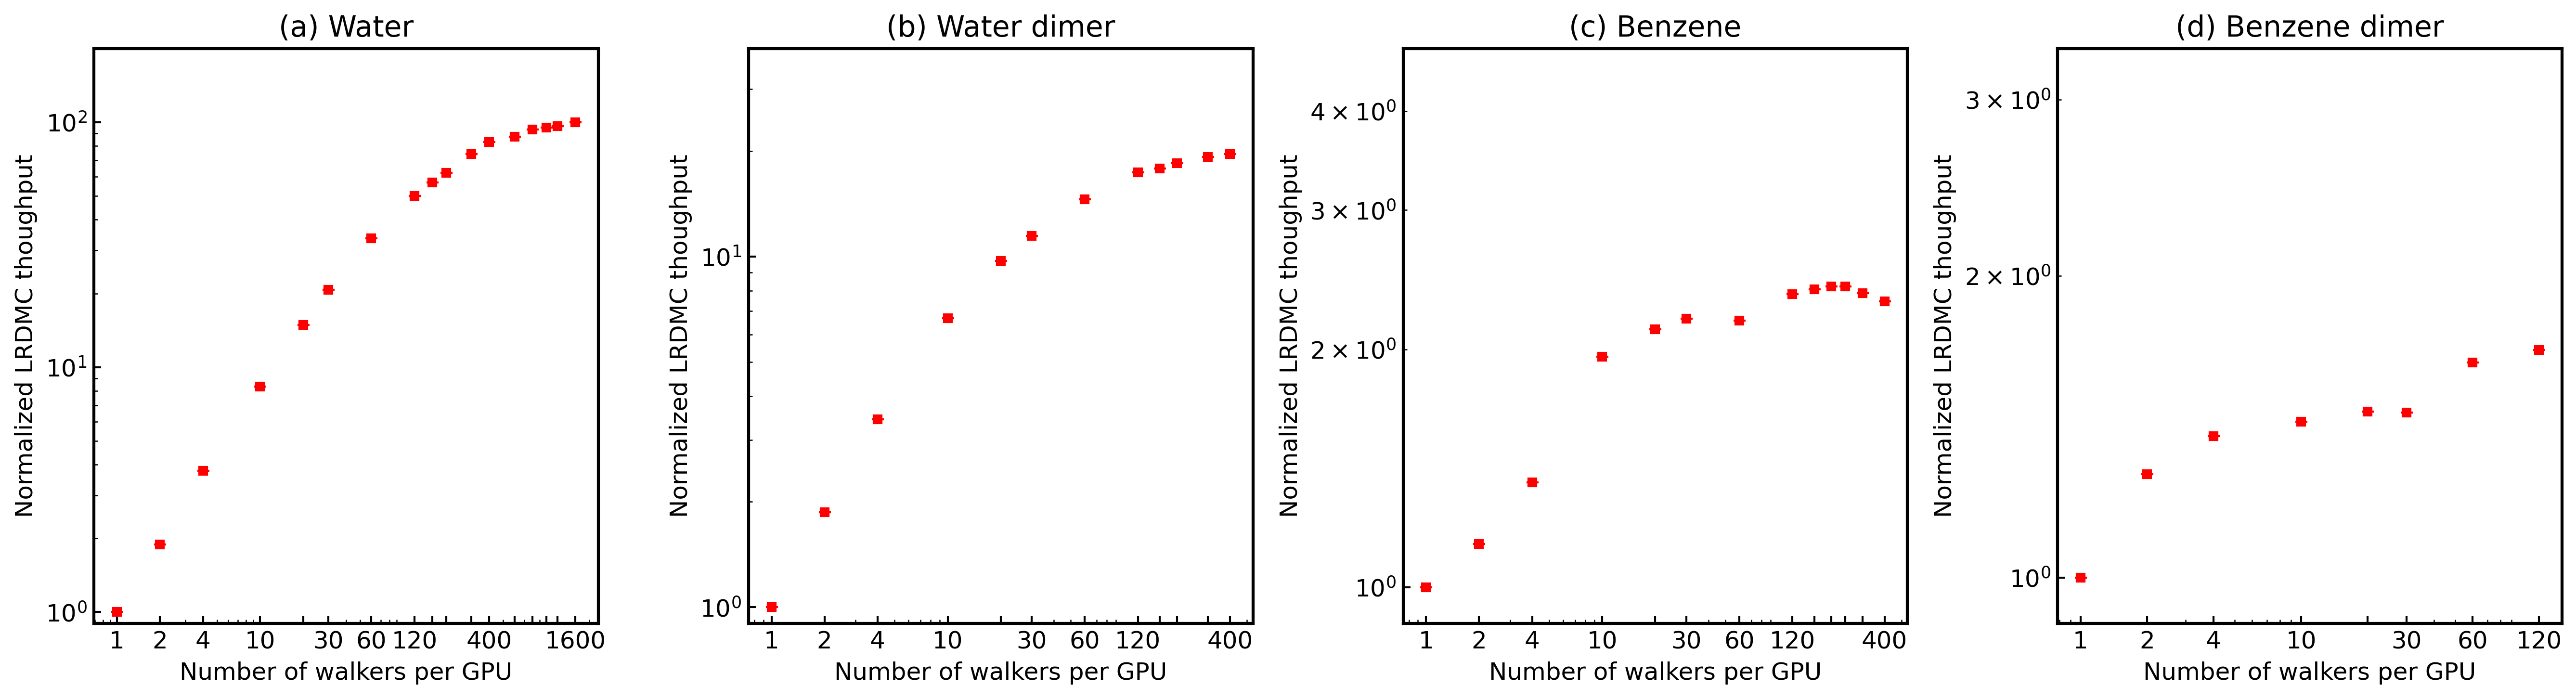

In [33]:
# plot Graph (lrdmc)
fig = plt.figure(figsize=(4.5 * len(mol_list), 5), facecolor="white", dpi=300, tight_layout=True)
plot_sigma=1
for i, mol in enumerate(mol_list):
    # plot Graph
    ax = fig.add_subplot(1, len(mol_list), i + 1)

    # labels
    ax.set_title(mol_label_list[i], wrap=True)
    ax.set_xlabel("Number of walkers per GPU")
    ax.set_ylabel(r"Normalized LRDMC thoughput")
    ax.set_xscale("log")
    ax.set_yscale("log")

    # GPU
    x = summary_lrdmc[mol]["lrdmc_num_nw_np"]
    y = summary_lrdmc[mol]["lrdmc_num_gfmc_num_walkers_per_sec_np"]/summary_lrdmc[mol]["lrdmc_num_gfmc_num_walkers_per_sec_np"][0]
    y_mean = np.array([v.n for v in y])
    y_std = np.array([v.s for v in y])
    ax.errorbar(x, y_mean, yerr=y_std*plot_sigma, color="r", marker="s", markersize=4, ls="", alpha=1.0, capsize=3)
    ax.set_xticks(summary_lrdmc[mol]["lrdmc_num_nw_np"])
    xticklabels = [str(t) for t in summary_lrdmc[mol]["lrdmc_num_nw_np"]]
    xticklabels = [
        "" if item in ["20", "160", "200", "240", "300", "360", "480", "600", "720", "800", "1000", "1200"] else item for item in xticklabels
    ]
    ax.set_xticklabels(xticklabels)
    
    ax.set_ylim([0.90, np.max(y_mean) * 2.0])

plt.savefig(f"jqmc_LRDMC_vectorization_benchmark.jpg")
plt.show()